In [139]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 17

import seaborn as sns
import re
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)

## 1. Data
##### Data Dictionary
company<br>
    - String, company names

description<br>
    - String, full text description of job

estimated_salary<br>
    - String, Indeed's salary estimation

extractDate<br>
    - String(?), date record was webscrapped

job_type_items<br>
    - String, formatted list of 'full-time', 'part-time', etc

location<br>
    - String, state and city/remote

postDate<br>
    - String, date job posting was created

rating<br>
    - Float, Indeed.com ascribed company ratings

raw_desc_soup<br>
    - String, raw full description, retained for possible future use/analysis

requirements<br>
    - String, employer-listed educational, aptitude, and experience requirements

sal_guide_items<br>
    - String, formatted list containing redundant characters and the Indeed salary estimate

salary<br>
    - String, if given by employer

salary_and_jType<br>
    - String, formatted list combining salary from salfromsection and job_type_items

salfromsection<br>
    - String, salary, if given, extracted from job description

summary<br>
    - String, brief summaries of each job extracted from sach results

title<br>
    - String, job position title

url<br>
    - String, job posting/description address

### 1.1 Load & Inspect Data

In [140]:
data = pd.read_csv('../app/data/total.csv')
# 1.1.1 Inspect Table
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           282 non-null    object 
 1   description       282 non-null    object 
 2   estimated_salary  40 non-null     object 
 3   extractDate       282 non-null    object 
 4   job_type_items    107 non-null    object 
 5   location          282 non-null    object 
 6   postDate          282 non-null    object 
 7   rating            218 non-null    float64
 8   raw_desc_soup     282 non-null    object 
 9   requirements      30 non-null     object 
 10  sal_guide_items   40 non-null     object 
 11  salary            109 non-null    object 
 12  salary_and_jType  199 non-null    object 
 13  salfromsection    109 non-null    object 
 14  summary           282 non-null    object 
 15  title             282 non-null    object 
 16  url               282 non-null    object 
dt

,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jType,salfromsection,summary,title,url
0,S&P Global,Panjiva is a data-driven technology company th...,NaN,2022-05-31,['Full-time'],United States,PostedToday,3.9,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,"$91,500 - $190,100 a year","$91,500 - $190,100 a year - Full-time","$91,500 - $190,100 a year",Working with our data scientists to turn large...,Data Engineer - Data Science Platforms & Infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
1,S&P Global,Panjiva is a data-driven technology company th...,NaN,2022-05-31,['Full-time'],United States,PostedToday,3.9,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,"$91,500 - $190,100 a year","$91,500 - $190,100 a year - Full-time","$91,500 - $190,100 a year",Working with our data scientists to turn large...,Data Engineer - Data Science Platforms & Infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
2,CyberCoders,Data Scientist If you are a Data Scient...,NaN,2022-05-31,['Full-time'],"Remote in Phoenix, AZ 85021",PostedToday,3.6,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,"$100,000 - $110,000 a year","$100,000 - $110,000 a year - Full-time","$100,000 - $110,000 a year",Collaborate with analytics teams to create ins...,Data Scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
3,Standard Chartered,Job: Data and Analytics Primary Location: As...,Estimated $105K - $133K a year,2022-05-31,NaN,"San Francisco, CA 94105 (Financial District/So...",PostedJust posted,4.1,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$105K - $133...",NaN,Full-time,NaN,Develop machine learning and advanced analytic...,Specialist Data Scientist,https://www.indeed.com/rc/clk?jk=0c043ee62c575...
4,Primary Talent Partners,Primary Talent Partner has an exciting 12 mont...,NaN,2022-05-31,"['Full-time', 'Contract']","San Jose, CA",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Bachelor's (Required)US work authorization (Re...,NaN,$65 - $70 an hour,"$65 - $70 an hour - Full-time, Contract",$65 - $70 an hour,"Understanding of statistical modeling, machine...",Sr. Data Analyst,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...


In [146]:
print(data.salary[-10:])

272     $91,500 - $190,100 a year
273                           NaN
274                           NaN
275     $91,500 - $190,100 a year
276                           NaN
277    $100,000 - $200,000 a year
278                           NaN
279     $91,500 - $190,100 a year
280     $91,500 - $190,100 a year
281     $91,500 - $190,100 a year
Name: salary, dtype: object


In [147]:
null = sum(data.salary.isnull())
nnull = sum(data.salary.notnull())
print('')
print(f'The data contains {data.shape[0]} rows of individual job postings with values for {data.shape[1]} columns based on\n different sections of each post\'s web page.')
print('')
print(f'- Out of {len(data)} job postings {nnull} or {round(nnull/len(data)*100,2)}% include some sort of salary information,\n- The remaining {null} rowws, or {round(null/len(data)*100,2)}% are missing salary data.\n- Also, there are no null values in the rest of the table meaning we won\'t need\n  to lose any data by dropping rows. While the null values in the Pay column will\n  simply be dropped after we translate the not nulls into the target.')


The data contains 282 rows of individual job postings with values for 17 columns based on
 different sections of each post's web page.

- Out of 282 job postings 109 or 38.65% include some sort of salary information,
- The remaining 173 rowws, or 61.35% are missing salary data.
- Also, there are no null values in the rest of the table meaning we won't need
  to lose any data by dropping rows. While the null values in the Pay column will
  simply be dropped after we translate the not nulls into the target.


    The following table is a view of the raw data from the scrape. I'll build the target by reducing the pay column to floating point values; this will require text cleaning which will also be conducted for the rest of the table. Location will be split into new columns for City and State while and because Indeed's search results show dates relative to the date the query was made I'll need to use PostDate and ExtractDate build a DatePosted column. It is important to note that JobUrl and date-related columns will not be converted into features for the logistic regression, instead they will be reattached to the data at the end in order to provide additional information and insights through the EC2 application. The only rows that'l  be using for modelling are JobTitle, Company, Summary, Requirements, and Description.

In [148]:
shape = data.shape
print(f"The {shape[0]} rows of data have {shape[1]} features. Since this is a classification problem I'll be selecting one to be the target, leaving me with {shape[1]-1} features to work with.")

The 282 rows of data have 17 features. Since this is a classification problem I'll be selecting one to be the target, leaving me with 16 features to work with.


In [149]:
#check for dupes
print(len(data[data.duplicated()]))


0


In [150]:
data[data.company == 'The Getch']

,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jType,salfromsection,summary,title,url


In [151]:
data.sal_guide_items[-5:-4]

277    NaN
Name: sal_guide_items, dtype: object

In [152]:
#check for missing
print(data.isna().sum().sort_values(ascending=False))

requirements        252
sal_guide_items     242
estimated_salary    242
job_type_items      175
salfromsection      173
salary              173
salary_and_jType     83
rating               64
url                   0
description           0
extractDate           0
raw_desc_soup         0
location              0
postDate              0
title                 0
summary               0
company               0
dtype: int64


The likelihood of seeing duplicates coming from the raw scrapping is very unlikely, but this is still a good check to do in case something changes with Indeed.com's front-end code.

Missing values are another story. It seems that Indeed.com doesn't require employers to provide values for every feature, this certainly seems to be the case with requirements, not to mention everywhere salary information coud be held.\
Others, like estimated salary and ratings are generated by Indeed.com but don't exist for every posting.\
job_type_items and salary_and_jType will likely be collapsed into a new column for job types, I'll also do the same with all of the salary related features to build the model's target.

In [153]:
# 1.1.2 Inspect & Modify Columns
data.nunique().sort_values(ascending=False)


raw_desc_soup       282
url                 194
description         110
summary             109
title                98
location             91
company              81
salary_and_jType     28
salfromsection       25
salary               25
sal_guide_items      25
estimated_salary     23
rating               17
requirements          8
postDate              3
job_type_items        3
extractDate           1
dtype: int64

In [154]:
data.columns = map(str.lower, data.columns)
# no need to change many column names because they're about to be dropped.
data = data.rename({'title': 'job_title'}, axis=1)

## 2. Preprocesing A
### 2.1 Reinspect Data

In [155]:
data.salary.unique()

array(['$91,500 - $190,100 a year', '$100,000 - $110,000 a year', nan,
       '$65 - $70 an hour', '$8,000 - $14,000 a month',
       '$180,000 - $225,000 a year', '$38.72 - $58.08 an hour',
       'From $52,000 a year', '$70 - $75 an hour',
       '$145,000 - $170,000 a year', '$80,000 - $105,000 a year',
       '$7,650 - $10,200 a month', '$130,000 - $160,000 a year',
       '$77,013 - $175,879 a year', '$106,823 - $138,868 a year',
       '$74,950 - $116,788 a year', '$110,000 - $160,000 a year',
       '$65.00 - $85.61 an hour', '$60,362 - $91,678 a year',
       '$70.42 an hour', 'Up to $66 an hour', '$60 an hour',
       '$130,000 - $200,000 a year', '$90,000 - $140,000 a year',
       '$67.00 - $86.50 an hour', '$100,000 - $200,000 a year'],
      dtype=object)

In [156]:
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           282 non-null    object 
 1   description       282 non-null    object 
 2   estimated_salary  40 non-null     object 
 3   extractdate       282 non-null    object 
 4   job_type_items    107 non-null    object 
 5   location          282 non-null    object 
 6   postdate          282 non-null    object 
 7   rating            218 non-null    float64
 8   raw_desc_soup     282 non-null    object 
 9   requirements      30 non-null     object 
 10  sal_guide_items   40 non-null     object 
 11  salary            109 non-null    object 
 12  salary_and_jtype  199 non-null    object 
 13  salfromsection    109 non-null    object 
 14  summary           282 non-null    object 
 15  job_title         282 non-null    object 
 16  url               282 non-null    object 
dt

,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jtype,salfromsection,summary,job_title,url
0,S&P Global,Panjiva is a data-driven technology company th...,NaN,2022-05-31,['Full-time'],United States,PostedToday,3.9,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,"$91,500 - $190,100 a year","$91,500 - $190,100 a year - Full-time","$91,500 - $190,100 a year",Working with our data scientists to turn large...,Data Engineer - Data Science Platforms & Infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
1,S&P Global,Panjiva is a data-driven technology company th...,NaN,2022-05-31,['Full-time'],United States,PostedToday,3.9,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,"$91,500 - $190,100 a year","$91,500 - $190,100 a year - Full-time","$91,500 - $190,100 a year",Working with our data scientists to turn large...,Data Engineer - Data Science Platforms & Infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
2,CyberCoders,Data Scientist If you are a Data Scient...,NaN,2022-05-31,['Full-time'],"Remote in Phoenix, AZ 85021",PostedToday,3.6,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,"$100,000 - $110,000 a year","$100,000 - $110,000 a year - Full-time","$100,000 - $110,000 a year",Collaborate with analytics teams to create ins...,Data Scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
3,Standard Chartered,Job: Data and Analytics Primary Location: As...,Estimated $105K - $133K a year,2022-05-31,NaN,"San Francisco, CA 94105 (Financial District/So...",PostedJust posted,4.1,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$105K - $133...",NaN,Full-time,NaN,Develop machine learning and advanced analytic...,Specialist Data Scientist,https://www.indeed.com/rc/clk?jk=0c043ee62c575...
4,Primary Talent Partners,Primary Talent Partner has an exciting 12 mont...,NaN,2022-05-31,"['Full-time', 'Contract']","San Jose, CA",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Bachelor's (Required)US work authorization (Re...,NaN,$65 - $70 an hour,"$65 - $70 an hour - Full-time, Contract",$65 - $70 an hour,"Understanding of statistical modeling, machine...",Sr. Data Analyst,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...


### 2.2 Diagnose Data
In order to proceed with any statistical or exploratory data analysis I will need to wrangle the data quite a bit.
Here, I'll list each of the current feature columns and briefly describe what I'll need to do with them.

In [157]:
# converting to lower and removing ounctuation/special charcters
#TODO remember to remove punct/spec - NPL may take care of this.
data.company.unique()[:10]

array(['S&P Global', 'CyberCoders', 'Standard Chartered',
       'Primary Talent Partners', 'YouAppi', 'ateliers artea worldwide',
       'TikTok', 'General Motors', 'JPMorgan Chase Bank, N.A.', 'Nielsen'],
      dtype=object)

'description'\
Each value is a unique string of the full job description. I'll lower and remove special characters but this feature will be dealt with seperately in its own NLP process.


In [158]:
data.description[0]

'Panjiva is a data-driven technology company that uses machine learning to provide powerful search, analysis, and visualization of billions of shipping records from nearly every country in the world. More than 3,000 customers in over 100 countries, ranging from Fortune 500 companies and startups to government agencies and hedge funds, rely on our platform for supply chain intelligence. In global trade, better insight means better decision making and stronger connections between companies and governments across the globe.Recognizing Panjiva’s cutting-edge technology, S&P Global acquired Panjiva in 2018. This acquisition has grown our resources, dramatically expanded our access to data, and accelerated our growth plans.People are Panjiva’s greatest strength – join our engineering team as we map out a key part of the world economy!Job DescriptionAs a data engineer on our team, you will play a key role in developing our next-generation data science infrastructure and underlying core techno

'estimated_salary'\
Indeed.com provides its own salary estimates in what appear to be bins.
These and all other salary ranges will be collapsed to their median values once I've extracted and converted their numeric string reresentations.


In [159]:
data.estimated_salary.unique()[:5]

array([nan, 'Estimated $105K - $133K a year',
       'Estimated $74.6K - $94.4K a year',
       'Estimated $104K - $131K a year',
       'Estimated $96.6K - $122K a year'], dtype=object)

'sal_guide_items'\
While I could convert these to lists, the only information I need (salary) can be parsed out.

In [160]:
data.sal_guide_items.unique()[:5]

array([nan,
       '[\'\', \'Not provided by employer\', "$105K - $133K a year is Indeed\'s estimated salary for this role in San Francisco, CA."]',
       '[\'\', \'Not provided by employer\', "$74.6K - $94.4K a year is Indeed\'s estimated salary for this role in Los Angeles, CA."]',
       '[\'\', \'Not provided by employer\', "$104K - $131K a year is Indeed\'s estimated salary for this role in San Francisco, CA."]',
       '[\'\', \'Not provided by employer\', "$105K - $133K a year is Indeed\'s estimated salary for this role in Mountain View, CA."]'],
      dtype=object)

'salary_and_jtype' & 'salfromsection'\
These will be wrangled in much the same way. The only other pertinent information in these features would be the job_type data already found in job_type_items,

In [161]:
data.salary_and_jtype.unique()[:3]

array(['$91,500 - $190,100 a year -  Full-time',
       '$100,000 - $110,000 a year -  Full-time', 'Full-time'],
      dtype=object)

In [162]:
data.salfromsection.unique()[:5]

array(['$91,500 - $190,100 a year', '$100,000 - $110,000 a year', nan,
       '$65 - $70 an hour', '$8,000 - $14,000 a month'], dtype=object)

'salary'\
Several different approaches will need to be used to extract salary information from this feature because employers provide this information themselves.
For one example, the pay periods of hour, day, week etc will need to be scaled to an anuual scale so I can have a standard scale to start wiith.
The salary ranges also appear here, so I'll be extracting numeric string characters, converting them into floats representing the lower and upper bounds of each range, and taking their medaian value.

In [163]:
data.salary.unique()[:5]

array(['$91,500 - $190,100 a year', '$100,000 - $110,000 a year', nan,
       '$65 - $70 an hour', '$8,000 - $14,000 a month'], dtype=object)

'extractdate' & 'postdate'\
extract_date is a string showing the day the record was webscrapped.
post_date is a string description of the relative age of each post from the date it was posted to the day it was webscrapped.
Converting post_date to a number will give me the the posts ae, which I'll then subtract from it's extract date in order to build a new feature carrying values for the DATE each job posting has been submitted to Indeed.com.


In [164]:
data.postdate.unique()[:5]

array(['PostedToday', 'PostedJust posted', 'Posted1 day ago'],
      dtype=object)

In [165]:
data.extractdate.unique()[:5]

array(['2022-05-31'], dtype=object)

'job_type_items'\
    I'm going to treat these as likert values, converrting each of these string formatted lists into an ordinal values for a new column.


In [166]:
data.job_type_items.unique()

array(["['Full-time']", nan, "['Full-time', 'Contract']", "['Contract']"],
      dtype=object)

'location'\
This feature holds a wealth of information: state, city/remote, and in some cases a zip code.
Zip codes seem to be a recent addition to the information I can get from Indeed.com but since its presence is rather sparse I'll just extract city/remote and state values, splitting them into their respective columns.

In [167]:
data.location.unique()[:5]

array(['United States', 'Remote in Phoenix, AZ 85021',
       'San Francisco, CA 94105 (Financial District/South Beach area)',
       'San Jose, CA', 'Los Angeles, CA'], dtype=object)

'rating'\
As the only feature coming in with numeric (float) values I should just need to scale it. I'll address missing values by imputing zero. The rationale behind this is that an unrated company should simply be rated as zero.

In [168]:
print(sorted(data.rating.unique()))

[2.3, 2.7, 2.8, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.1, nan, 4.0, 4.2, 4.3, 4.4, 4.7]


'raw_desc_soup'\
I'm only saving this in case I refine or change my parsing. Below is a truncated slice of one of the raw records.

In [169]:
data.raw_desc_soup[1][:1000]

'<!DOCTYPE html>\n\n<html dir="ltr" lang="en">\n<head>\n<script crossorigin="anonymous" defer="" src="//d3fw5vlhllyvee.cloudfront.net/m/s/3604791a85306d36c1c0/scripts/viewjob.js"></script>\n<title>Data Engineer - Data Science Platforms &amp; Infrastructure Virtual Hiring Event - United States - Indeed.com</title><meta charset="utf-8"/><meta content="ie=edge" http-equiv="x-ua-compatible"/><meta content="notranslate" name="google"/><meta content="width=device-width, initial-scale=1" name="viewport"/><meta content="noindex" name="robots"/><meta content="https://www.indeed.com/viewjob?from=appsharedroid&amp;jk=8bc23ede4c38917a" id="indeed-share-url"/><meta content="Data Engineer - Data Science Platforms &amp; Infrastructure Virtual Hiring Event" id="indeed-share-message"/><meta content="simple" id="indeed-share-type"/><meta content="Data Engineer - Data Science Platforms &amp; Infrastructure Virtual Hiring Event - United States - Indeed.com" property="og:title"/><meta content="Data Enginee

'requirements'\
I will most likely merge this in with the description prior to conducting NLP. The rationale is that these explicit requirements may be echoed in the description or summary, so by adding them to the corpus I'll raise the scores derived from their increaseed frequency. Eventually I wiuld like to build a set of requirements that I can use in with a clustering algorithm, like KNN, to find/define subgroups within the sample population.

In [170]:
data.requirements[0]

nan

'summary'\
Much like the description, these are unique. COming from the search results page itself, these are brief descriptions of each job. In most cases this is not merely an abridgement of the summary. Like 'requirement' I'll start by lumping these texts in with description so analysis of the corpus can be boosted by the added descriptions.

In [171]:
for i in data.summary[:3]:
    print(i)

Working with our data scientists to turn large-scale messy, diverse, and often unstructured data into a source of meaningful insights for our customers.
Working with our data scientists to turn large-scale messy, diverse, and often unstructured data into a source of meaningful insights for our customers.
Collaborate with analytics teams to create insights from data to be presented to clients. Translate data analysis to guide business decisions.


'job_title'\
Although the webscrapper searches for 'data scientist' the results contain over 80 unique job titles. This is largely due to a prefix or suffix that provides the role's specialization at that particular company for that particular job posting. These include items like 'Marketing', 'Senior', 'Geospatial...'.
I'll start by cleaning and simplifying these values, i.e. appearences of 'Sr' can be converted to 'Senior'. This will significantly reduce the number of unique values, hopefully increasing model accuracy.

In [172]:
print(len(data.job_title.unique()))
data.job_title.unique()[:10]

98


array(['Data Engineer - Data Science Platforms & Infrastructure Virt...',
       'Data Scientist', 'Specialist Data Scientist', 'Sr. Data Analyst',
       'ML Engineer', 'DATA SCIENTIST', 'Lead Threat Data Scientist',
       'BrightDrop - Head of Data Science and Engineering',
       'ARTIFICIAL INTELLIGENCE RESEARCHER', 'VP, Data Scientist Lead'],
      dtype=object)

'url'\
Like raw_doc_soup, I'm simply keeping these in case I need to go back and re-parse the raw data. In fact, this URL points directly to the page where that raw doc soup is found.
I may also be able to detect job post updates and duplicates by using these unique addresses.

In [173]:
data.url[0]

'https://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0Btxs39KmTzjw_u_hUXcyTcLpNeUj18C2Nw5A7DCW0FWOPSvZxadnbHHa0I4XPLZEq_Gh4iXyDpyXtpEN8kkOpLkj0yDBzti5wdrNykHulDaOwJKpF2-6RvM53kF1Nc3PQ4_ZOWn9sDxI-MnVL2OZsS8Hw2kb8gqRReiUmZ9sR7fXkBI84UA_l6cJpvUdxqNArOzlZAVDykqFE9U7x_GUvZ0P0Y77dQRr63plseWsN4jV0C_CdEojiMnZl6xlYCKb-_Tyml77EKc4Xl6bGXfTfUBaUmkhgELeTJovp38fx6sBEw5evv25GzQHL0SD4Pl3k4pJPaueaKpLs_zs-tYQ94txR9cBJjG7XOFVGnIQxotY5o5vmUfq6VMiVjfQDrxlER2lTYwEh_lXzcRsjQWCkDW2mHug7JcjrzULSrap7MXiqSJm88NerxOqtYZKuEZwWVKEmdHKG6d775v80lz8U4jDFRLrd2Wni1x8yW233d_JA3E4RH3zGcLBP4zkJq013stq7DP2eamOq0fNA9lYd7nq5ZgnqbbH4XTiea_ikhVQMdRt3dN1RGJYI1On9Mb34IgOvXS-1DwSNDQFIV3C3r_hPRzvTBHwZz5T4pzUO_pgJyTNLk5iFMJliYaOuQlCdLYigSoGtsppjNGD1XCwfZcc-OAYjlZ89lHcr7krO25n4qtwaGCXdMs21s82_LN21F9HHRPqjkzx3Ge8xfnn9b&p=0&fvj=0&vjs=3'

### 2.3 Wrangling & Feature Engineering
Below are the implementations of the data wrangling steps I described above for each feature. Using Numpy, Regex, and Pandas I'll simutaneaously clean the strings, extract and convert numeric information, and create new feature columns.

In [174]:

def sal_chars(data):
    """When applied, substitutes '' for any listed special characters, 

    Args:
        data (column values): I call this function on specific columns. Data, in this case, represents that column and its values.

    Returns:
        string: the original string values, sans any listed special characters.
    """
    cleaned = re.sub(r'[\n|,|+|$|[|$|\'|"]',r'',data)
    return cleaned

def sal_splitter(data):
    """Splits off salary information from a string formatted list

    Args:
        data (column values):  I call this function on specific columns. Data, in this case, represents that column and its values.

    Returns:
        string: returns the split containing salary information.
    """
    x = data.split(',')
    return x[2]

def Pay_period(data):
    """Used in the creation of a temporary column that will be discarded once I use it to generate a annualized salary column.

    Args:
        data (string): I call this function on specific columns. Data, in this case, represents that column and its values.

    Returns:
        string: pay rate descripions
    """
    z = ''
    substrings = ['hour','day','week','year']
    for i in substrings:
        if i in data:
            return i
        else:
            continue

def jobtype(data):
    """Used for creating a new feature containing nominal values for the job type.

    Args:
        data (string): Values from the 'job_type_items' column.

    Returns:
        string: Extracted and simplified values for each category.
    """
    if type(data) == str:
        if re.search('full', data):
            out = 'full'
        if re.search('part', data):
            out = 'part'
        if re.search('contract', data):
            out = 'contract'
        if re.search('temp', data):
            out = 'temp'
        return out
    else:
        pass

def annual(data):
    """Annualizes salary data

    Args:
        data (dataframe): the entire dataframe is passed through.

    Returns:
        string: In the new 'annual_sal' column, creates annualized salaries by multiplying them against the observed (and previously extracted) pay rates.
    """
    data['annual_sal'] = np.nan
    data['annual_sal'] = np.where(data['schedule'].str.contains("hour"), data.salary*40*(365/7), data['salary'])
    #data['annual_sal'] = np.where(data['schedule'].str.contains("day"), data['salary']*365/7*5, data['salary'])
    #data['annual_sal'] = np.where(data['schedule'].str.contains("week"), data['salary']*365/7, data['salary'])
    #data['annual_sal'] = np.where(data['schedule'].str.contains("month"), data['salary']*365/12, data['salary'])
    #data['annual_sal'] = np.where(data['schedule'].str.contains("year"), data['salary']/100, data['salary'])
    return data

def split_sal(i):
    try:
        lst = i.split('-',1)
        x = lst[0]
        y = lst[1]
        
        y = re.sub(r'[–]',r'',y)

        return (float(x)+float(y))/2
    except:
        return i

In [175]:
salary = data[data.salary.notnull()]
data[['salary',]] = salary['salary'].apply(sal_chars)


In [176]:


estimated_salary = data[data.estimated_salary.notnull()]
data['estimated_salary'] = estimated_salary['estimated_salary'].apply(sal_chars)


In [177]:

salfromsection = data[data.salfromsection.notnull()]
data[['salfromsection',]] = salfromsection['salfromsection'].apply(sal_chars)

salary_and_jtype = data[data.salfromsection.notnull()]
data[['salary_and_jtype',]] = salary_and_jtype['salary_and_jtype'].apply(sal_chars)




In [178]:


sal_guide_arr = data[data.sal_guide_items.notnull()]
data[['sal_guide_items']] = sal_guide_arr['sal_guide_items'].apply(sal_splitter)

sal_guide_arr = data[data.sal_guide_items.notnull()]
data[['sal_guide_items']] = sal_guide_arr['sal_guide_items'].apply(sal_chars)


In [179]:


estimated_salary = data[data['estimated_salary'].notnull()]
data['Schedule1'] = estimated_salary['estimated_salary'].apply(Pay_period)

sal_guide_items = data[data['sal_guide_items'].notnull()]
data['Schedule2'] = sal_guide_items['sal_guide_items'].apply(Pay_period)

salary = data[data['salary'].notnull()]
data['Schedule3'] = salary['salary'].apply(Pay_period)

salary_and_jtype = data[data['salary_and_jtype'].notnull()]
data['Schedule4'] = salary_and_jtype['salary_and_jtype'].apply(Pay_period)

salfromsection = data[data['salfromsection'].notnull()]
data['Schedule5'] = salfromsection['salfromsection'].apply(Pay_period)

val_cols = ['Schedule1','Schedule2','Schedule3','Schedule4','Schedule5']
data['schedule'] = data[val_cols].bfill(axis=1).iloc[:, 0]
data.drop(val_cols,inplace=True,axis=1)



In [180]:
def splitter(data):
    lst = []
    if type(data) ==  str:
        for val in re.findall('([0-9\.]+)',data):
            lst.append(val)
        if len(lst) > 1:
            return (float(lst[0])+float(lst[1]))/2
        #



            

                    
                
     
            
        
        


data['estimated_salary'] = data['estimated_salary'].apply(splitter)
data['salary'] = data['salary'].apply(splitter)
col = ['estimated_salary','salary']
data['salary'] = data[col].bfill(axis=1).iloc[:, 0]
data

,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jtype,salfromsection,summary,job_title,url,schedule
0,S&P Global,Panjiva is a data-driven technology company th...,NaN,2022-05-31,['Full-time'],United States,PostedToday,3.9,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,140800.0,91500 - 190100 a year - Full-time,91500 - 190100 a year,Working with our data scientists to turn large...,Data Engineer - Data Science Platforms & Infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,year
1,S&P Global,Panjiva is a data-driven technology company th...,NaN,2022-05-31,['Full-time'],United States,PostedToday,3.9,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,140800.0,91500 - 190100 a year - Full-time,91500 - 190100 a year,Working with our data scientists to turn large...,Data Engineer - Data Science Platforms & Infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,year
2,CyberCoders,Data Scientist If you are a Data Scient...,NaN,2022-05-31,['Full-time'],"Remote in Phoenix, AZ 85021",PostedToday,3.6,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,105000.0,100000 - 110000 a year - Full-time,100000 - 110000 a year,Collaborate with analytics teams to create ins...,Data Scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,year
3,Standard Chartered,Job: Data and Analytics Primary Location: As...,119.0,2022-05-31,NaN,"San Francisco, CA 94105 (Financial District/So...",PostedJust posted,4.1,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,105K - 133K a year is Indeeds estimated salar...,119.0,NaN,NaN,Develop machine learning and advanced analytic...,Specialist Data Scientist,https://www.indeed.com/rc/clk?jk=0c043ee62c575...,year
4,Primary Talent Partners,Primary Talent Partner has an exciting 12 mont...,NaN,2022-05-31,"['Full-time', 'Contract']","San Jose, CA",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Bachelor's (Required)US work authorization (Re...,NaN,67.5,65 - 70 an hour - Full-time Contract,65 - 70 an hour,"Understanding of statistical modeling, machine...",Sr. Data Analyst,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,hour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,CyberCoders,Remote Unity AI Engineer If you are a R...,NaN,2022-05-31,['Full-time'],"Remote in Seattle, WA 98109",PostedToday,3.6,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,150000.0,100000 - 200000 a year - Full-time,100000 - 200000 a year,"Experience with creating modding tools, or any...",Remote Unity AI Engineer,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,year
278,Amazon.com Services LLC,PhD degree with 4 years of applied research ex...,NaN,2022-05-31,NaN,"Seattle, WA",Posted1 day ago,3.5,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,NaN,NaN,NaN,The Model accelerator and Data platform is loo...,"Applied Science Manager, Model Accelerator and...",https://www.indeed.com/rc/clk?jk=f088d36c6064a...,NaN
279,S&P Global,Panjiva is a data-driven technology company th...,NaN,2022-05-31,['Full-time'],United States,PostedToday,3.9,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,140800.0,91500 - 190100 a year - Full-time,91500 - 190100 a year,Working with our data scientists to turn large...,Data Engineer - Data Science Platforms & Infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,year
280,S&P Global,Panjiva is a data-driven technology company th...,NaN,2022-05-31,['Full-time'],United States,PostedToday,3.9,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,140800.0,91500 - 190100 a year - Full-time,91500 - 190100 a year,Working with our data scientists to turn large...,Data Engineer - Data Science Platforms & Infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,year


In [181]:


cols = ['company','description', 'job_type_items','location','postdate','requirements',	'summary','job_title']
for txt_col in cols:
    data[txt_col] = data[txt_col].str.lower()



data['jobtype'] = data.job_type_items.apply(jobtype)

data['text'] = data.description+' '+data.summary
#TODO add requirements

cols = ['job_type_items','raw_desc_soup','url','description','summary','requirements']


data.text = data.text.replace(')',' ')



data = annual(data)
#data.schedule.value_counts() keep and eye on this, may have to deal with more than just hourly

In [182]:
def reducer(data):
    if data > 1000:
        return round(data/1000)
    elif data > 1:
        return round(data)
    else:
        return data
    
data['final_sal'] = data.annual_sal.apply(reducer)



def restorer(data):
    if data > 1:
        return data*1000
    else:
        return data
data['final_sal'] = data.final_sal.apply(restorer)

In [183]:
data

,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,raw_desc_soup,requirements,...,salary_and_jtype,salfromsection,summary,job_title,url,schedule,jobtype,text,annual_sal,final_sal
0,s&p global,panjiva is a data-driven technology company th...,NaN,2022-05-31,['full-time'],united states,postedtoday,3.9,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,91500 - 190100 a year - Full-time,91500 - 190100 a year,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,year,full,panjiva is a data-driven technology company th...,140800.000000,141000.0
1,s&p global,panjiva is a data-driven technology company th...,NaN,2022-05-31,['full-time'],united states,postedtoday,3.9,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,91500 - 190100 a year - Full-time,91500 - 190100 a year,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,year,full,panjiva is a data-driven technology company th...,140800.000000,141000.0
2,cybercoders,data scientist if you are a data scient...,NaN,2022-05-31,['full-time'],"remote in phoenix, az 85021",postedtoday,3.6,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,100000 - 110000 a year - Full-time,100000 - 110000 a year,collaborate with analytics teams to create ins...,data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,year,full,data scientist if you are a data scient...,105000.000000,105000.0
3,standard chartered,job: data and analytics primary location: as...,119.0,2022-05-31,NaN,"san francisco, ca 94105 (financial district/so...",postedjust posted,4.1,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,NaN,NaN,develop machine learning and advanced analytic...,specialist data scientist,https://www.indeed.com/rc/clk?jk=0c043ee62c575...,year,None,job: data and analytics primary location: as...,119.000000,119000.0
4,primary talent partners,primary talent partner has an exciting 12 mont...,NaN,2022-05-31,"['full-time', 'contract']","san jose, ca",postedjust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",bachelor's (required)us work authorization (re...,...,65 - 70 an hour - Full-time Contract,65 - 70 an hour,"understanding of statistical modeling, machine...",sr. data analyst,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,hour,contract,primary talent partner has an exciting 12 mont...,140785.714286,141000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,cybercoders,remote unity ai engineer if you are a r...,NaN,2022-05-31,['full-time'],"remote in seattle, wa 98109",postedtoday,3.6,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,100000 - 200000 a year - Full-time,100000 - 200000 a year,"experience with creating modding tools, or any...",remote unity ai engineer,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,year,full,remote unity ai engineer if you are a r...,150000.000000,150000.0
278,amazon.com services llc,phd degree with 4 years of applied research ex...,NaN,2022-05-31,NaN,"seattle, wa",posted1 day ago,3.5,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,NaN,NaN,the model accelerator and data platform is loo...,"applied science manager, model accelerator and...",https://www.indeed.com/rc/clk?jk=f088d36c6064a...,NaN,None,phd degree with 4 years of applied research ex...,NaN,NaN
279,s&p global,panjiva is a data-driven technology company th...,NaN,2022-05-31,['full-time'],united states,postedtoday,3.9,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,91500 - 190100 a year - Full-time,91500 - 190100 a year,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,year,full,panjiva is a data-driven technology company th...

Let's see what the data looks like at this point. It looks like the 17 original features have been reduced to 11. Most of the columns have been collapsed and cleaned, too. Just a bit more work till this is ready for EDA, NLP, and transformations.

In [184]:
data.salary

0      140800.0
1      140800.0
2      105000.0
3         119.0
4          67.5
         ...   
277    150000.0
278         NaN
279    140800.0
280    140800.0
281    140800.0
Name: salary, Length: 282, dtype: float64

In [185]:
def postD(data):
    """Critical function that converts postdate values into relative (in days) distance from the extract date.

    Args:
        data (string): text descrption of how old the post is.

    Returns:
        npnan or int: numeric representation of post age
    """
    if data != np.nan:
        rid = ['active','%+ days ago','+']
        for i in rid:
            if i in data:
                return np.nan
        
        rid2 = ['just posted','today','postedjust posted','postedtoday','hiring ongoing']
        for i in rid2:
            if i in data:
                return 0   
            
        rid3 = ['posted1 day ago']
        for i in rid3:
            if i in data:
                return 1


    #data['dateposted'] = data['dateposted'].astype('int')
    return data

def pDate(row):
    """Subtracts the distance (in days) provided by the postD function.
    Args:
        row (record in the data): record

    Returns:
        datetime object: extract date - relative age = actual post date
    """

    days_ago = row['dateposted']
    delta = timedelta(days_ago)
    try:
        return row['extractdate'] - delta
    except:
        return row

def sal_fixer(data):
    """Ensures that all salaries are on the same annualized scale.

    Args:
        data (float): values from the salary column

    Returns:
        float: annualized salary
    """
    if type(data) != np.nan:
        data = round(data,0)

        if len(str(data)) < 5:
            data*=1000
    else:
        pass
    return data

In [186]:
data['dateposted'] = data.postdate.apply(postD)
data['extractdate']= pd.to_datetime(data['extractdate'])

data['dateposted'] = data.apply( lambda row : pDate(row), axis = 1)


data.rating = data.rating.fillna(0)

cols = ['extractdate','postdate','schedule','jobtype','salary']
data.drop(cols,inplace=True,axis=1)
data = data.rename({'annual_sal': 'salary'}, axis=1)

data['salary'] = data['salary'].apply(sal_fixer)

In [187]:
data.salary

0      140800.0
1      140800.0
2      105000.0
3         119.0
4      140786.0
         ...   
277    150000.0
278         NaN
279    140800.0
280    140800.0
281    140800.0
Name: salary, Length: 282, dtype: float64

In [188]:
def states_(i):
    """Extracts state values from location

    Args:
        i (string): values from location

    Returns:
        string: extracted state value
    """
    if ',' in i:
        fix =  i.partition(',')[2].strip()
        if len(fix) >2:
            return fix[:2]
        else:
            return fix
    if ',' not in i:
        return i
    elif 'remote' in i:
        return 'remote'


def cities_(i):
    """Extracts city values from location

    Args:
        i (string): values from location

    Returns:
        string: extracted city value
    """
    if ',' in i:
        return i.partition(',')[0]
    if ',' not in i:
        return i
    elif 'remote' in i:
        return 'remote'

data['state'] = data.location.apply(states_)
data['city'] = data["location"].apply(cities_)
#data[data.state.isnull()] = 'remote'

In [189]:
data.columns
cols = ['salary','estimated_salary', 'job_type_items','raw_desc_soup', 'sal_guide_items','salary_and_jtype', 'salfromsection']
data.drop(cols,inplace=True,axis=1)
data.rename(columns={'final_sal': 'salary'},inplace=True)

### 2.4 Assessment

In [190]:
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   company       282 non-null    object        
 1   description   282 non-null    object        
 2   location      282 non-null    object        
 3   rating        282 non-null    float64       
 4   requirements  30 non-null     object        
 5   summary       282 non-null    object        
 6   job_title     282 non-null    object        
 7   url           282 non-null    object        
 8   text          282 non-null    object        
 9   salary        138 non-null    float64       
 10  dateposted    282 non-null    datetime64[ns]
 11  state         282 non-null    object        
 12  city          282 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(10)
memory usage: 4.6 MB


,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
0,s&p global,panjiva is a data-driven technology company th...,united states,3.9,NaN,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data-driven technology company th...,141000.0,2022-05-31,united states,united states
1,s&p global,panjiva is a data-driven technology company th...,united states,3.9,NaN,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data-driven technology company th...,141000.0,2022-05-31,united states,united states
2,cybercoders,data scientist if you are a data scient...,"remote in phoenix, az 85021",3.6,NaN,collaborate with analytics teams to create ins...,data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,data scientist if you are a data scient...,105000.0,2022-05-31,az,remote in phoenix
3,standard chartered,job: data and analytics primary location: as...,"san francisco, ca 94105 (financial district/so...",4.1,NaN,develop machine learning and advanced analytic...,specialist data scientist,https://www.indeed.com/rc/clk?jk=0c043ee62c575...,job: data and analytics primary location: as...,119000.0,2022-05-31,ca,san francisco
4,primary talent partners,primary talent partner has an exciting 12 mont...,"san jose, ca",0.0,bachelor's (required)us work authorization (re...,"understanding of statistical modeling, machine...",sr. data analyst,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,primary talent partner has an exciting 12 mont...,141000.0,2022-05-31,ca,san jose


In [191]:
shape = data.shape
print(f"The {shape[0]} rows of data now have {shape[1]} variables whose values are now cleaned and typed properly.\nThe only missing values are in Salary which is my target.\nNext, I'll conduct analysis, encoding, and scaling of each feature, starting with Salary which .")
data.describe(include = 'all')


The 282 rows of data now have 13 variables whose values are now cleaned and typed properly.
The only missing values are in Salary which is my target.
Next, I'll conduct analysis, encoding, and scaling of each feature, starting with Salary which .


,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
count,282,282,282,282.000000,30,282,282,282,282,138.000000,282,282,282
unique,81,110,91,NaN,8,109,97,194,115,NaN,2,31,74
top,s&p global,panjiva is a data-driven technology company th...,remote,NaN,us work authorization (required)bachelor's (pr...,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/rc/clk?jk=4b6823194171a...,panjiva is a data-driven technology company th...,NaN,2022-05-31 00:00:00,remote,remote
freq,43,43,56,NaN,8,43,43,10,43,NaN,265,56,56
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-30 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-31 00:00:00,NaN,NaN
mean,NaN,NaN,NaN,2.926596,NaN,NaN,NaN,NaN,NaN,121992.753623,NaN,NaN,NaN
std,NaN,NaN,NaN,1.614713,NaN,NaN,NaN,NaN,NaN,39305.001702,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,9000.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,3.200000,NaN,NaN,NaN,NaN,NaN,105500.000000,NaN,NaN,NaN


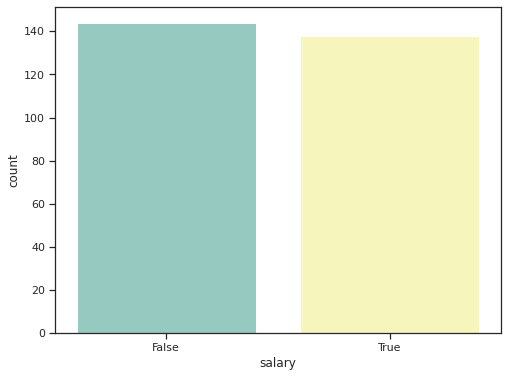

In [192]:
sns.countplot(x='salary', data=data.notnull(), palette='Set3')
plt.show()

In [193]:
null = len(data[data.salary.isnull()])
nnull = len(data[data.salary.notnull()])
print(f'{round(nnull/len(data)*100,2)}% of the data has salary information, should be an easy target')

48.94% of the data has salary information, should be an easy target


In [194]:
data.to_csv(f'../app/data/wrangled_data.csv', index=False)

In [195]:
data

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
0,s&p global,panjiva is a data-driven technology company th...,united states,3.9,NaN,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data-driven technology company th...,141000.0,2022-05-31,united states,united states
1,s&p global,panjiva is a data-driven technology company th...,united states,3.9,NaN,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data-driven technology company th...,141000.0,2022-05-31,united states,united states
2,cybercoders,data scientist if you are a data scient...,"remote in phoenix, az 85021",3.6,NaN,collaborate with analytics teams to create ins...,data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,data scientist if you are a data scient...,105000.0,2022-05-31,az,remote in phoenix
3,standard chartered,job: data and analytics primary location: as...,"san francisco, ca 94105 (financial district/so...",4.1,NaN,develop machine learning and advanced analytic...,specialist data scientist,https://www.indeed.com/rc/clk?jk=0c043ee62c575...,job: data and analytics primary location: as...,119000.0,2022-05-31,ca,san francisco
4,primary talent partners,primary talent partner has an exciting 12 mont...,"san jose, ca",0.0,bachelor's (required)us work authorization (re...,"understanding of statistical modeling, machine...",sr. data analyst,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,primary talent partner has an exciting 12 mont...,141000.0,2022-05-31,ca,san jose
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,cybercoders,remote unity ai engineer if you are a r...,"remote in seattle, wa 98109",3.6,NaN,"experience with creating modding tools, or any...",remote unity ai engineer,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,remote unity ai engineer if you are a r...,150000.0,2022-05-31,wa,remote in seattle
278,amazon.com services llc,phd degree with 4 years of applied research ex...,"seattle, wa",3.5,NaN,the model accelerator and data platform is loo...,"applied science manager, model accelerator and...",https://www.indeed.com/rc/clk?jk=f088d36c6064a...,phd degree with 4 years of applied research ex...,NaN,2022-05-30,wa,seattle
279,s&p global,panjiva is a data-driven technology company th...,united states,3.9,NaN,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data-driven technology company th...,141000.0,2022-05-31,united states,united states
280,s&p global,panjiva is a data-driven technology company th...,united states,3.9,NaN,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data-driven technology company th...,141000.0,2022-05-31,united states,united states


In [196]:
munged = data
munged

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
0,s&p global,panjiva is a data-driven technology company th...,united states,3.9,NaN,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data-driven technology company th...,141000.0,2022-05-31,united states,united states
1,s&p global,panjiva is a data-driven technology company th...,united states,3.9,NaN,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data-driven technology company th...,141000.0,2022-05-31,united states,united states
2,cybercoders,data scientist if you are a data scient...,"remote in phoenix, az 85021",3.6,NaN,collaborate with analytics teams to create ins...,data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,data scientist if you are a data scient...,105000.0,2022-05-31,az,remote in phoenix
3,standard chartered,job: data and analytics primary location: as...,"san francisco, ca 94105 (financial district/so...",4.1,NaN,develop machine learning and advanced analytic...,specialist data scientist,https://www.indeed.com/rc/clk?jk=0c043ee62c575...,job: data and analytics primary location: as...,119000.0,2022-05-31,ca,san francisco
4,primary talent partners,primary talent partner has an exciting 12 mont...,"san jose, ca",0.0,bachelor's (required)us work authorization (re...,"understanding of statistical modeling, machine...",sr. data analyst,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,primary talent partner has an exciting 12 mont...,141000.0,2022-05-31,ca,san jose
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,cybercoders,remote unity ai engineer if you are a r...,"remote in seattle, wa 98109",3.6,NaN,"experience with creating modding tools, or any...",remote unity ai engineer,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,remote unity ai engineer if you are a r...,150000.0,2022-05-31,wa,remote in seattle
278,amazon.com services llc,phd degree with 4 years of applied research ex...,"seattle, wa",3.5,NaN,the model accelerator and data platform is loo...,"applied science manager, model accelerator and...",https://www.indeed.com/rc/clk?jk=f088d36c6064a...,phd degree with 4 years of applied research ex...,NaN,2022-05-30,wa,seattle
279,s&p global,panjiva is a data-driven technology company th...,united states,3.9,NaN,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data-driven technology company th...,141000.0,2022-05-31,united states,united states
280,s&p global,panjiva is a data-driven technology company th...,united states,3.9,NaN,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data-driven technology company th...,141000.0,2022-05-31,united states,united states


In [197]:
null = len(munged[munged.salary.isnull()])
nnull = len(munged[munged.salary.notnull()])
print(f'Droping {len(data)-len(munged)} duplicates and out of date posts leaves {len(munged)} rows of data for the regressor to be trained and tested on.')
print(f'- Of those {len(munged)} job postings {nnull} or {round(nnull/len(munged)*100,2)}% include salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}% are missing salary data.')

Droping 0 duplicates and out of date posts leaves 282 rows of data for the regressor to be trained and tested on.
- Of those 282 job postings 138 or 48.94% include salary information,
- The remaining 144 rows, or 51.06% are missing salary data.


## Detecting Outliers: Using both the Z-Score and IQR methods
    Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

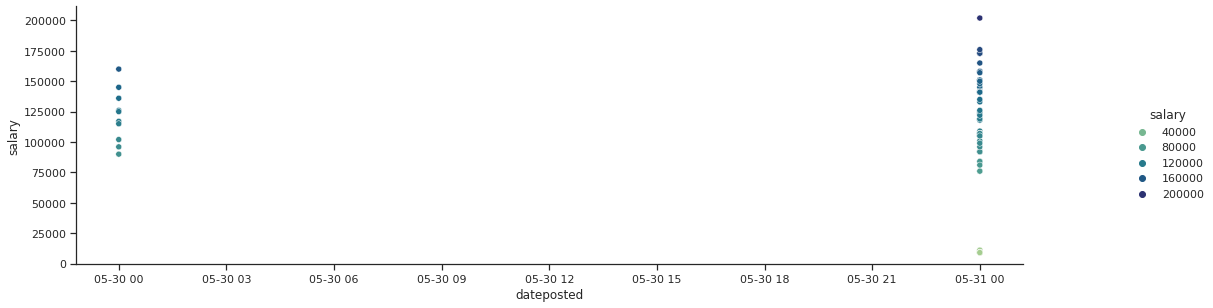

In [198]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.

In [199]:
outliers = []
def z_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
z_detect(munged)

#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.

In [200]:
def iqr_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    Q1, Q3 = np.percentile(sample,[25,75])
    iqr = Q3-Q1
    lower_bound = Q1-(1.5*iqr)
    upper_bound = Q3+(1.5*iqr)
    for i in sample:
        if (i < lower_bound)  | (i > upper_bound):
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
set(iqr_detect(munged))

{9000.0, 11000.0, 202000.0}

In [201]:
def unique(list1):
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x)
        
mn = min(outliers)
mx = max(outliers)
print(f'The {len(set(outliers))} Unique Outliers Are:')
unique(outliers)
print(f'- With a minumum of ${round(mn)} and a maximum of ${round(mx)}')

The 3 Unique Outliers Are:
11000.0
202000.0
9000.0
- With a minumum of $9000 and a maximum of $202000


In [202]:
# Take a look at those tables.

outliers = munged[munged['salary'].isin(outliers)]
munged.drop(outliers.index, axis=0,inplace=True)
outliers

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
14,ntuc income insurance co-operative ltd,"location singapore, central singapore pla...","marina, ca",0.0,NaN,the successful candidate will bring a vision t...,data architect (informatica & cloud),https://www.indeed.com/rc/clk?jk=dc709d8dc5be4...,"location singapore, central singapore pla...",11000.0,2022-05-31,ca,marina
27,ntuc income insurance co-operative ltd,"location singapore, central singapore pla...","marina, ca",0.0,NaN,the successful candidate will bring a vision t...,data architect (informatica & cloud),https://www.indeed.com/rc/clk?jk=dc709d8dc5be4...,"location singapore, central singapore pla...",11000.0,2022-05-31,ca,marina
32,cybercoders,staff data scientist job title: staff data...,"remote in mountain view, ca 94043+2 locations",3.6,NaN,work closely with data engineers to implement ...,staff data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,staff data scientist job title: staff data...,202000.0,2022-05-31,ca,remote in mountain view
59,saif,"us-remote while it may sound ornate to us now,...",remote,3.7,NaN,minimum 4 years of design and production autom...,machine learning engineer,https://www.indeed.com/company/SAIF-CORPORATIO...,"us-remote while it may sound ornate to us now,...",9000.0,2022-05-31,remote,remote
74,saif,"us-remote while it may sound ornate to us now,...",remote,3.7,NaN,if you’d like to help shape the contours of wh...,machine learning engineer,https://www.indeed.com/company/SAIF-CORPORATIO...,"us-remote while it may sound ornate to us now,...",9000.0,2022-05-31,remote,remote
86,saif,"us-remote while it may sound ornate to us now,...",remote,3.7,NaN,minimum 4 years of design and production autom...,machine learning engineer,https://www.indeed.com/company/SAIF-CORPORATIO...,"us-remote while it may sound ornate to us now,...",9000.0,2022-05-31,remote,remote
101,saif,"us-remote while it may sound ornate to us now,...",remote,3.7,NaN,minimum 4 years of design and production autom...,machine learning engineer,https://www.indeed.com/company/SAIF-CORPORATIO...,"us-remote while it may sound ornate to us now,...",9000.0,2022-05-31,remote,remote
119,saif,"us-remote while it may sound ornate to us now,...",remote,3.7,NaN,minimum 4 years of design and production autom...,machine learning engineer,https://www.indeed.com/company/SAIF-CORPORATIO...,"us-remote while it may sound ornate to us now,...",9000.0,2022-05-31,remote,remote
134,saif,"us-remote while it may sound ornate to us now,...",remote,3.7,NaN,minimum 4 years of design and production autom...,machine learning engineer,https://www.indeed.com/company/SAIF-CORPORATIO...,"us-remote while it may sound ornate to us now,...",9000.0,2022-05-31,remote,remote
149,saif,"us-remote while it may sound ornate to us now,...",remote,3.7,NaN,minimum 4 years of design and production autom...,machine learning engineer,https://www.indeed.com/company/SAIF-CORPORATIO...,"us-remote while it may sound ornate to us now,...",9000.0,2022-05-31,remote,remote


In [203]:
null = len(munged[munged.salary.isnull()])

nnull = len(munged[munged.salary.notnull()])

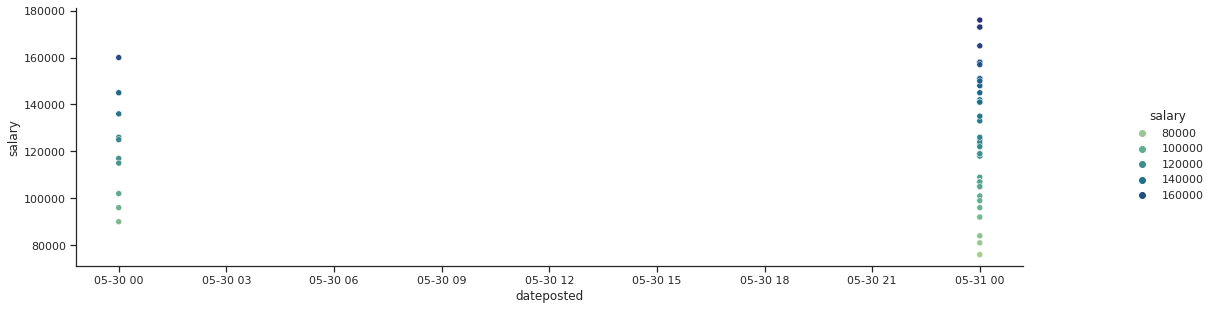

In [204]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

- Dropping 11 outliers now leaves 127, or 46.86%, of rows with with salary information,
- The remaining 144 rows, or 53.14%, are missing salary data.


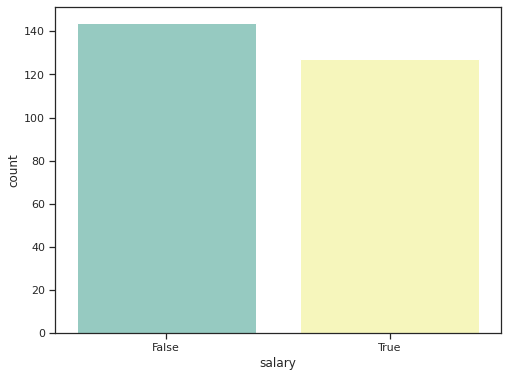

In [205]:
sns.countplot(x='salary', data=munged.notnull(), palette='Set3')
print(f'- Dropping {len(outliers)} outliers now leaves {nnull}, or {round(nnull/len(munged)*100,2)}%, of rows with with salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}%, are missing salary data.')


In [206]:
munged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 0 to 281
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   company       271 non-null    object        
 1   description   271 non-null    object        
 2   location      271 non-null    object        
 3   rating        271 non-null    float64       
 4   requirements  30 non-null     object        
 5   summary       271 non-null    object        
 6   job_title     271 non-null    object        
 7   url           271 non-null    object        
 8   text          271 non-null    object        
 9   salary        127 non-null    float64       
 10  dateposted    271 non-null    datetime64[ns]
 11  state         271 non-null    object        
 12  city          271 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(10)
memory usage: 39.6+ KB


In [207]:
munged.to_csv(f'../app/data/wrangled_data.csv', index=False)

In [208]:
munged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 0 to 281
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   company       271 non-null    object        
 1   description   271 non-null    object        
 2   location      271 non-null    object        
 3   rating        271 non-null    float64       
 4   requirements  30 non-null     object        
 5   summary       271 non-null    object        
 6   job_title     271 non-null    object        
 7   url           271 non-null    object        
 8   text          271 non-null    object        
 9   salary        127 non-null    float64       
 10  dateposted    271 non-null    datetime64[ns]
 11  state         271 non-null    object        
 12  city          271 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(10)
memory usage: 39.6+ KB


In [209]:
munged.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 0 to 281
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   company       271 non-null    object        
 1   description   271 non-null    object        
 2   location      271 non-null    object        
 3   rating        271 non-null    float64       
 4   requirements  30 non-null     object        
 5   summary       271 non-null    object        
 6   job_title     271 non-null    object        
 7   url           271 non-null    object        
 8   text          271 non-null    object        
 9   salary        127 non-null    float64       
 10  dateposted    271 non-null    datetime64[ns]
 11  state         271 non-null    object        
 12  city          271 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(10)
memory usage: 4.5 MB


In [210]:
munged.drop('location',inplace=True,axis=1)

In [211]:
munged.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 0 to 281
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   company       271 non-null    object        
 1   description   271 non-null    object        
 2   rating        271 non-null    float64       
 3   requirements  30 non-null     object        
 4   summary       271 non-null    object        
 5   job_title     271 non-null    object        
 6   url           271 non-null    object        
 7   text          271 non-null    object        
 8   salary        127 non-null    float64       
 9   dateposted    271 non-null    datetime64[ns]
 10  state         271 non-null    object        
 11  city          271 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 4.5 MB
